In [1]:
# our basic libraries
import torch
from torch import nn
from torch import optim
import torchvision

import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import helper

In [2]:
data_dir = 'data'

train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

torch.Size([3, 224, 224])


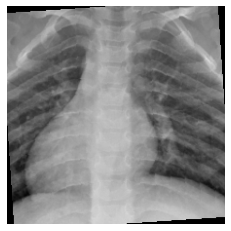

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);
print(image[0,:].shape)

In [4]:
model = models.densenet121(pretrained=True)
# print(model)

In [5]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [8]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [9]:
epochs = 4
print_every = 1
steps = 0
model.to(device)

for e in range(epochs):
    model.train()
    running_loss = 0
    model.to(device)
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        # Move input and label tensors to the GPU
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
             # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

            model.train()
            running_loss = 0

Epoch: 1/4..  Training Loss: 0.719..  Test Loss: 0.603..  Test Accuracy: 0.812
Epoch: 1/4..  Training Loss: 0.720..  Test Loss: 0.588..  Test Accuracy: 0.812
Epoch: 1/4..  Training Loss: 0.671..  Test Loss: 0.574..  Test Accuracy: 0.812
Epoch: 1/4..  Training Loss: 0.656..  Test Loss: 0.561..  Test Accuracy: 0.812
Epoch: 1/4..  Training Loss: 0.707..  Test Loss: 0.573..  Test Accuracy: 0.823
Epoch: 1/4..  Training Loss: 0.688..  Test Loss: 0.604..  Test Accuracy: 0.778
Epoch: 1/4..  Training Loss: 0.610..  Test Loss: 0.637..  Test Accuracy: 0.778
Epoch: 1/4..  Training Loss: 0.684..  Test Loss: 0.653..  Test Accuracy: 0.747
Epoch: 1/4..  Training Loss: 0.632..  Test Loss: 0.654..  Test Accuracy: 0.747
Epoch: 1/4..  Training Loss: 0.582..  Test Loss: 0.656..  Test Accuracy: 0.726
Epoch: 2/4..  Training Loss: 0.539..  Test Loss: 0.666..  Test Accuracy: 0.705
Epoch: 2/4..  Training Loss: 0.564..  Test Loss: 0.682..  Test Accuracy: 0.587
Epoch: 2/4..  Training Loss: 0.624..  Test Loss: 0.6

tensor([[-0.2535, -1.4966],
        [-1.0900, -0.4098],
        [-0.1254, -2.1381],
        [-0.7318, -0.6559],
        [-0.2422, -1.5367],
        [-1.9109, -0.1601],
        [-0.0844, -2.5140],
        [-1.7120, -0.1991],
        [-0.1139, -2.2286],
        [-0.1439, -2.0095],
        [-0.2638, -1.4617],
        [-0.4213, -1.0676],
        [-0.0621, -2.8092],
        [-1.7260, -0.1960],
        [-3.2260, -0.0405],
        [-0.0161, -4.1340]], device='cuda:0')


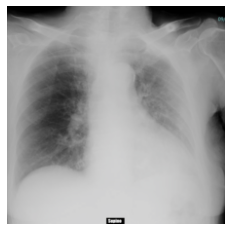

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

img = images[6]
# Convert 2D image to 1D vector

# TODO: Calculate the class u (softmax) for img
with torch.no_grad():
    logits = model.forward(images)
ps = F.softmax(logits, dim=1)
print(logits)

# Plot the image and probabilities
helper.imshow(img.cpu());